# 1D Poisson solver with FFT

We implement a FFT solver for 

$$
\begin{align}
 - \phi''(x) & = \rho(x) & \qquad x & \in (a,b) \subset \mathbb R\,,
 \\[1mm]
 \phi(a) & = \phi(b)
\end{align}
$$

See the [third exercise sheet](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/CompPlasmaPhys22/exercise03.pdf) for details.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

In [5]:
N = 8

# matrix assembly:
v0 = np.ones(N)*(2)
v1 = np.ones(N-1)*(-1)
Ah = np.diag(v0) + np.diag(v1, 1) + np.diag(v1, -1)
Ah[0, -1] = -1   # periodicity
Ah[-1, 0] = -1   # periodicity

# Compute eigenvalues and print the one with the smallest absolute value
eig_vals = np.linalg.eigvals(Ah)
print('smallest eigenvalue:', np.min(np.abs(eig_vals)))

smallest eigenvalue: 2.220446049250313e-16


N =    8
L1-error:,  0.1335432
L2-error:  0.1766610
Linf-error:  0.2337006

N =   16
L1-error:,  0.0341397
L2-error:  0.0387271
Linf-error:  0.0530293

N =   32
L1-error:,  0.0084010
L2-error:  0.0093041
Linf-error:  0.0129507

N =   64
L1-error:,  0.0020751
L2-error:  0.0022941
Linf-error:  0.0032190

N =  128
L1-error:,  0.0005152
L2-error:  0.0005704
Linf-error:  0.0008036

N =  256
L1-error:,  0.0001283
L2-error:  0.0001423
Linf-error:  0.0002008

N =  512
L1-error:,  0.0000320
L2-error:  0.0000355
Linf-error:  0.0000502

N = 1024
L1-error:,  0.0000080
L2-error:  0.0000089
Linf-error:  0.0000126

convergence rate with L1: 2.0070422805242214
convergence rate with L2: 2.029918037413738
convergence rate with Linf: 2.018449301811946


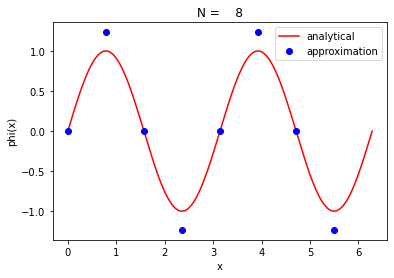

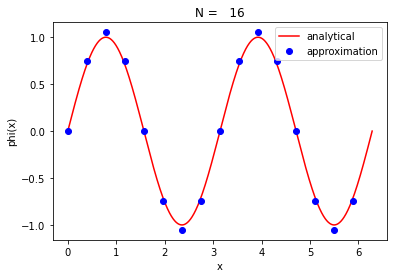

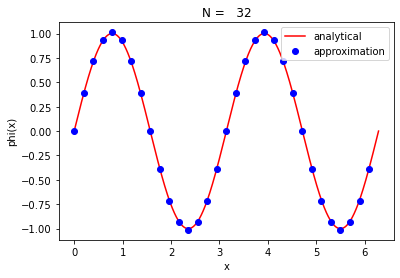

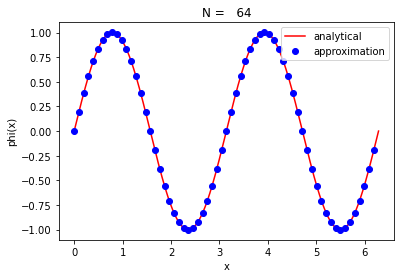

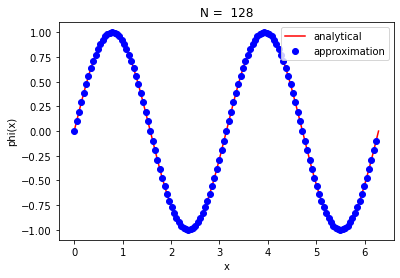

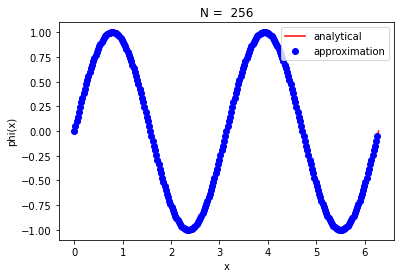

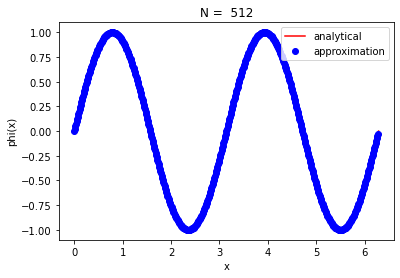

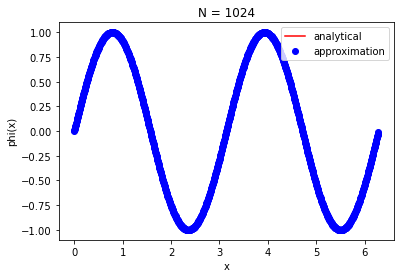

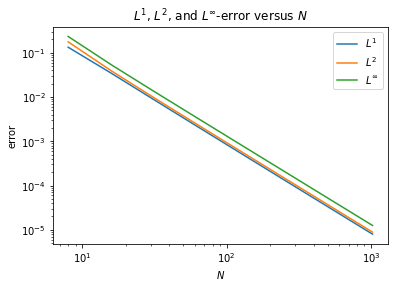

In [32]:
# Discretize the domain
a = 0
b = 2*np.pi
L = b-a
N_vec = [2**k for k in range(3, 11)]


# analytical solution (for testing purposes):
phi_ana = lambda x: np.sin(2*x)

# method of manufactured solutions: 
# insert analytical solution into Poisson equation to compute the rhs.
rho = lambda x: 4*np.sin(2*x)

# create array to save errors
L1_arr   = np.empty( len(N_vec) )
L2_arr   = np.empty( len(N_vec) )
Linf_arr = np.empty( len(N_vec) )

#create continuous mesh and analytical solution for nice plot
x_cont   = np.linspace(a,b,1000)
phi_cont = phi_ana( x_cont )

# do the convergence study:
for m,N in enumerate(N_vec):
    
    # grid:
    x_arr = np.linspace(a,b,N+1)
    h = L/N
    
    # rho:
    rho_vec = rho(x_arr[:-1])

    P_inv = 1j * np.ones([N, N])
    P     = 1j * np.ones([N, N])
    
    for k in range(N):
        for l in range(N):
            P[k,l]     =  1 / np.sqrt(N) * np.exp(-2j * np.pi * k * l / N)    # fill the FT matrix with entries exp( -2i*pi*k*l/N ) for k,l=0,..,N-1
            P_inv[l,k] =  1 / np.sqrt(N) * np.exp(2j * np.pi * k * l / N)   # fill the inverse FT matrix with entries 1/N * exp( 2i*pi*k*l/N ) for k,l=0,..,N-1
    
    #print(np.matmul(P_inv, P))
    # P is an unitary matrix here, which is a small change

    # matrix assembly:
    v0 = np.ones(N)*(2)
    v1 = np.ones(N-1)*(-1)
    Ah = np.diag(v0) + np.diag(v1, 1) + np.diag(v1, -1)
    Ah[0, -1] = -1   # periodicity
    Ah[-1, 0] = -1   # periodicity
    Ah /= h**2
    
    
    # Compute the eigenvalue matrix and cut out 0-th mode
    
    Lambda = np.sqrt(N) * P.dot(Ah[0, :]) # a clever way to compute lambdas
    #print(Lambda)
    #Lambda   = np.linalg.eigvals(Ah)
    
    Lambda_c = Lambda[1:] # cutting out the 0-th mode
    
    
    # apply inverse FT to rho_vec
    rho_hat = P_inv.dot( rho_vec )
    
    #print(rho_hat.shape)

    # multiply with the inverse of Lambda
    phi_hat = rho_hat[1:] / Lambda_c
    
    # add value for phi_hat_0 on top of rho_hat to obtain phi_hat

    phi_hat = np.append([-np.sum(phi_hat)], phi_hat)



    # tranform back with the FT to obtain phi_h
    phi_h = P.dot(phi_hat)
    
    phi_h = phi_h.real
    

    # compare to the analytical solution at the grid points:
    phi = phi_ana(x_arr[:-1])
    
    L1_err   = np.sum( np.abs( phi-phi_h ) )/(N-1)
    L2_err   = np.sqrt( np.sum( np.abs( phi-phi_h )**2 )/(N-1) )
    Linf_err = np.max( np.abs( phi-phi_h ) )
    
    # Print out N and the errors
    print( 'N = {:4d}'.format(N))
    print('L1-error:, {:10.7f}'.format(L1_err))
    print('L2-error:','{:10.7f}'.format(L2_err))
    print('Linf-error:','{:10.7f}'.format(Linf_err))
    print()
    
    L1_arr[m]   = L1_err
    L2_arr[m]   = L2_err
    Linf_arr[m] = Linf_err
    
    plt.figure()
    plt.plot(x_cont, phi_cont, 'r-', label='analytical')
    plt.plot(x_arr[:-1], phi_h, 'ob', label='approximation')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('phi(x)')
    plt.title('N = {:4d}'.format(N))
    
plt.figure()
plt.plot(N_vec, L1_arr, label='$L^1$')
plt.plot(N_vec, L2_arr, label='$L^2$')
plt.plot(N_vec, Linf_arr, label='$L^\infty$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('$N$')
plt.ylabel('error')
plt.title('$L^1$, $L^2$, and $L^\infty$-error versus $N$')

#L1_rate   = (np.log(L1_arr[0]) - np.log(L1_arr[-1])) / (np.log(N_vec[0]) - np.log(N_vec[-1]))
#L2_rate   = (np.log(L2_arr[0]) - np.log(L2_arr[-1])) / (np.log(N_vec[0]) - np.log(N_vec[-1]))
#Linf_rate = (np.log(Linf_arr[0]) - np.log(Linf_arr[-1])) / (np.log(N_vec[0]) - np.log(N_vec[-1]))

L1_rate   = -np.polyfit(np.log(N_vec), np.log(L1_arr),1)[0] # y = k*x + b; k shows the rate (gives better evaluation)
L2_rate   = -np.polyfit(np.log(N_vec), np.log(L2_arr),1)[0]
Linf_rate = -np.polyfit(np.log(N_vec), np.log(Linf_arr),1)[0]

print('convergence rate with L1:', L1_rate)
print('convergence rate with L2:', L2_rate)
print('convergence rate with Linf:', Linf_rate)